### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Visualización

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya


### Objetivos:

* Generar un corpus con todos los documentos. 

* Dividir el corpus en tokens, graficar el histograma de frecuencia de palabras demostrando la ley Zipf. 

* Analizar palabras más frecuentes y menos frecuentes. Seleccionar 5 documentos de cada fuero y realizar el mismo análisis. ¿Se repiten las palabras? 

* Hacer lo mismo con n-gramas.

* Visualizar la frecuencia de palabras en una nube de palabras.

* Elaborar una breve conclusión de lo encontrado

Fecha de Entrega: 20 de mayo de 2022

In [66]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords

In [67]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_sm")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')

### Funciones que vamos a utilizar en el Práctico

##### Funciones auxiliares

In [68]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = dirName + "\\" + file
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split("\\")[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles


def save_to_pickle(obj, filename):
    """
    TODO: [E111] Pickling a token is not supported, because tokens are only views of the parent Doc and can't exist on
    their own. A pickled token would always have to include its Doc and Vocab, which has practically no advantage over
    pickling the parent Doc directly. So instead of pickling the token, pickle the Doc it belongs to.
    :param obj:
    :param filename:
    :return:
    """

    file_path = f"{CURR_DIR}\\{filename}"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'rb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)



##### Funciones específicas del análisis

In [69]:
def get_palabras(files_path, fuero_name=None, ngrams=False, breakpoint=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si Breakpoint != None, dar el número de docs con el que se interrumpe la función
    """
    corpus = {}

    corpus_list = []

    palabras = []

    i = 0
    for filename in getListOfFiles(files_path):
        file_name = filename.split("\\")[-1]
        fuero = fuero_name if fuero_name is not None else filename.split("\\")[-2]
        if fuero not in corpus.keys():
            corpus[fuero] = {}

        # Creamos este diccionario para luego utilizarlo para armar un dataframe
        corpus_dict = {'fuero': fuero,
                       'documento': file_name}

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()

            nlp_doc = nlp(file_text)
            corpus[fuero][file_name] = nlp_doc
            corpus_dict['texto'] = nlp_doc
            corpus_list.append(corpus_dict)
            if ngrams:
                nlp_doc = nlp_doc.noun_chunks
            for token in nlp_doc:
                if ngrams:
                    palabras.append(token)
                elif token.is_alpha:  # si es sólo alfabético
                    palabras.append(token)
        # remover esta sección (testing)
        if breakpoint:
            i += 1
            if i > breakpoint:
                break
    return palabras, corpus


def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)


def show_histogram(dataframe, threshold=1):
    """Función que plotea un histograma
    """
    dataframe[dataframe > threshold].plot(kind='bar')
    plt.show()


def plot_create_subplots(n_subplots, sup_title, n_rows = 5, share_x=False, fig_size=(16, 16)):
    sns.set(style="darkgrid")
    n_ratio = int(n_subplots/n_rows) 
    n_cols = n_ratio if n_subplots % n_rows == 0 else n_ratio + 1
    fig, axes = plt.subplots(n_rows, n_cols, sharex=share_x, figsize=fig_size)
    fig.suptitle(sup_title)
    return fig, axes
    
    
def plot_histogram(dataframe, threshold=1, y_low=50):
    """
    sns.set(style="darkgrid")
    
    fig = plt.figure(figsize=(10,6))
    
    sns.catplot(
                kind="bar",
                data=dataframe[dataframe > threshold]
               ).set(ylabel='Frecuencia de Palabras',
                     xlabel='Palabra',
                     title='Distribución de Frecuencia de Palabras')
    plt.show()
    """
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    plt.figure(figsize=(20, 8), dpi=80)
    
    x=dataframe[:threshold].index 
    y=dataframe[:threshold].values
    
    my_color = np.where(y>=y_low, 'orange', 'skyblue')
    
    # The vertical plot is made using the vline function
    plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4)
    plt.scatter(x, y, color=my_color, s=1, alpha=1)

    # Add title and axis names
    plt.title("Distribución de Frecuencia de Palabras", loc='left')
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia de Palabras')
    plt.xticks(rotation = 45) 

    # Show the graph
    plt.show()
    
def show_zipf(dataframe):
    """Función que grafica la Ley de Zipf (scatterplot con ejes en escala logarítmica)
    """
    sns.set(style="darkgrid")
    
    rank_palabras = [x + 1 for x in range(len(dataframe))]
    
    sns.scatterplot(x=rank_palabras,
                    y=dataframe).set(xscale="log",
                                yscale="log",
                                ylabel='log(Frecuencia)',
                                xlabel='log(Orden)')
    
    plt.show()
    
    
def comparar_frecuencias_palabras(dataframe, max_palabras=50 ,description=None):
    """Función que compara entre las palabras más y menos frecuentes 
    """
    if description:
        print(description)
    print(
        f"\nLas {max_palabras} palabras más frecuentes son:\n{dataframe.head(max_palabras)}"
    )  # La mayoría son todas stopwords, a partir de la 20ma empiezan a haber palabras propias del ámbito jurídico
    
    print(f"\nLas {max_palabras} palabras menos frecuentes son:\n{dataframe.tail(max_palabras)}"
    )  # palabras normales pero donde la mayoría comparte una base en común (e.g. ordenadas, ordenado, ordenando) >> con lematización, se podría disminuir esto
    
    return dataframe.head(max_palabras).index.values


def get_n_grams(tokens, n):
    """Función que genera n-gramas en base a una lista de tokens de SpaCy
    """
    return [' '.join([token.text for token in tokens[i:i+n]]) for i in range(len(tokens) - n + 1)]


def generar_wordcloud(img_name, stopwords, tokens, output_path):
    """Función que genera una nube de palabras (wordcloud) sobre una imagen de fondo.    
    """
    
    image_name = f"img/{img_name}.jpg" 

    
    # Generate a word cloud image
    mask = np.array(Image.open(image_name))
    text = ' '.join(
        [token.text for token in tokens])
    wordcloud_law = WordCloud(
        stopwords=stopwords,
        background_color="white", 
        mode="RGBA",
        max_words=1000,
        mask=mask).generate(text)
    
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7, 7])
    plt.imshow(wordcloud_law.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    
    # store to file
    plt.savefig(output_path, format="png")
    
    plt.show()

### Análisis de los documentos







#### Generar un corpus con todos los documentos

In [70]:
# Ubicación de los documentos
filesDir = f"{CURR_DIR}\Documentos"

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

In [71]:
# Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
palabras, corpus_dic = get_palabras(filesDir, breakpoint=None)

frecuencia_palabras_df = get_conteo_palabras(palabras)

print(frecuencia_palabras_df.head())

palabra
de     1921
la     1436
que    1150
el      915
en      892
Name: palabra, dtype: int64


#### Análisis de palabras para todos los docs

##### Ley de Zipf
Analizamos las frecuencias de las palabras para determinar si se verifica la ley de Zipf.
El primer gráfico corresponde a la distribución de las palabras que se repiten al menos 50 veces.
En el segundo gráfico se muestran las frecuencias vs el orden de las palabras en escala logarítmica (ambos ejes).
Ambos gráficos confirman un comportamiento exponencial.

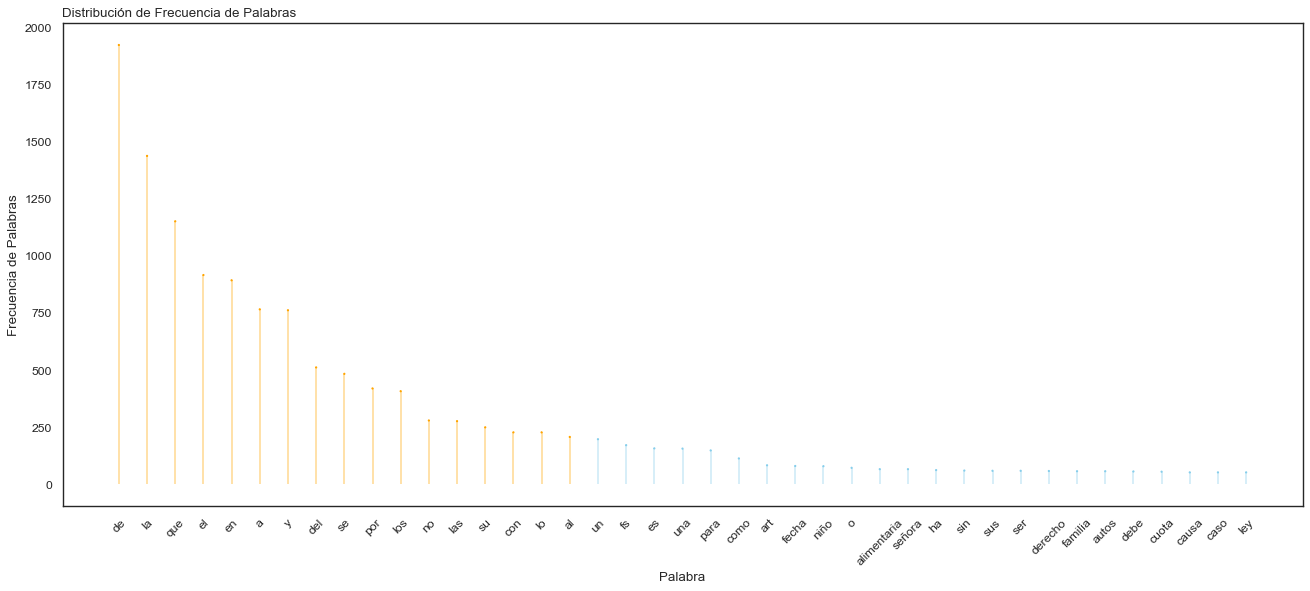

In [72]:
#show_histogram(frecuencia_palabras_df, threshold=1)
plot_histogram(
    frecuencia_palabras_df,
    threshold=50,  # Nos quedamos con las 50 palabras más frecuentes
    y_low=200)

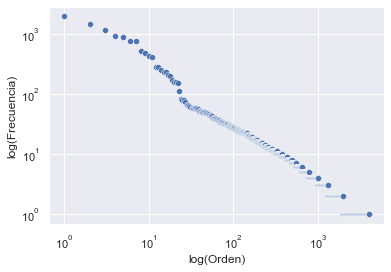

In [73]:
show_zipf(frecuencia_palabras_df)

##### Analizar palabras más frecuentes y menos frecuentes (todos los docs)
Analizar palabras más frecuentes y menos frecuentes.

In [74]:
comparar_frecuencias_palabras(frecuencia_palabras_df)


Las 50 palabras más frecuentes son:
palabra
de             1921
la             1436
que            1150
el              915
en              892
a               765
y               761
del             511
se              483
por             419
los             407
no              279
las             276
su              249
con             227
lo              227
al              207
un              197
fs              171
es              157
una             156
para            148
como            113
art              83
fecha            80
niño             79
o                72
alimentaria      66
señora           66
ha               62
sin              60
sus              59
ser              59
derecho          58
familia          57
autos            57
debe             56
cuota            55
causa            52
caso             52
ley              52
si               49
este             49
hijos            49
partes           49
civil            49
le               48
recurso        

array(['de', 'la', 'que', 'el', 'en', 'a', 'y', 'del', 'se', 'por', 'los',
       'no', 'las', 'su', 'con', 'lo', 'al', 'un', 'fs', 'es', 'una',
       'para', 'como', 'art', 'fecha', 'niño', 'o', 'alimentaria',
       'señora', 'ha', 'sin', 'sus', 'ser', 'derecho', 'familia', 'autos',
       'debe', 'cuota', 'causa', 'caso', 'ley', 'si', 'este', 'hijos',
       'partes', 'civil', 'le', 'recurso', 'más', 'señor'], dtype=object)

Las palabras más frecuentes son las denominadas "stopwords", como por ejemplo: "de", "la", "que", etc. 
Las palabras menos frecuentes en sí son genéricas, que se pueden encontrar en cualquier contexto, no necesariamente vinculadas al ámbito jurídico/legal. También vemos que hay muchas palabras que corresponden a variaciones de la misma raíz, e.g. allanarse, allanar

##### Visualizar la frecuencia de palabras en una nube de palabras

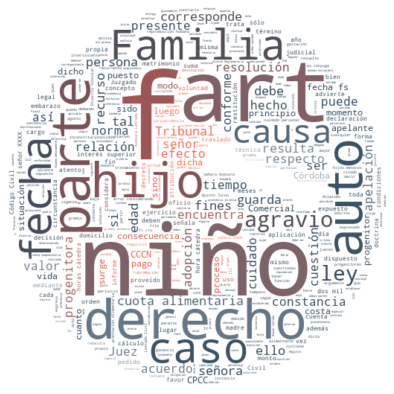

In [75]:
img_name = "legal-icon-png"
output_name = f"img/{img_name}_wordcloud.png"

generar_wordcloud(img_name, STOPWORDS_ES, palabras, output_name)

#### Análisis de palabras por fueros

##### Analizar palabras más frecuentes y menos frecuentes (por fueros)
Analizar palabras más frecuentes y menos frecuentes. Seleccionar 5 documentos de cada fuero y realizar el mismo análisis. ¿Se repiten las palabras?

Fuero: FAMILIA


Las 50 palabras más frecuentes son:
palabra
de             39435
la             28160
que            20593
el             17195
en             15132
y              13305
a              12664
del             9255
por             8744
los             8294
se              7766
no              5472
las             4780
su              4703
lo              4570
al              4335
con             4070
fs              3193
es              2879
un              2649
una             2567
para            2554
art             2096
como            1776
ha              1754
recurso         1632
fecha           1624
ley             1525
familia         1433
o               1344
apelación       1300
sus             1268
cuota           1225
señora          1192
alimentaria     1187
debe            1170
ser             1150
ello            1147
parte           1071
autos           1065
señor           1065
tribunal         950
este             941
mil              932
resolución     

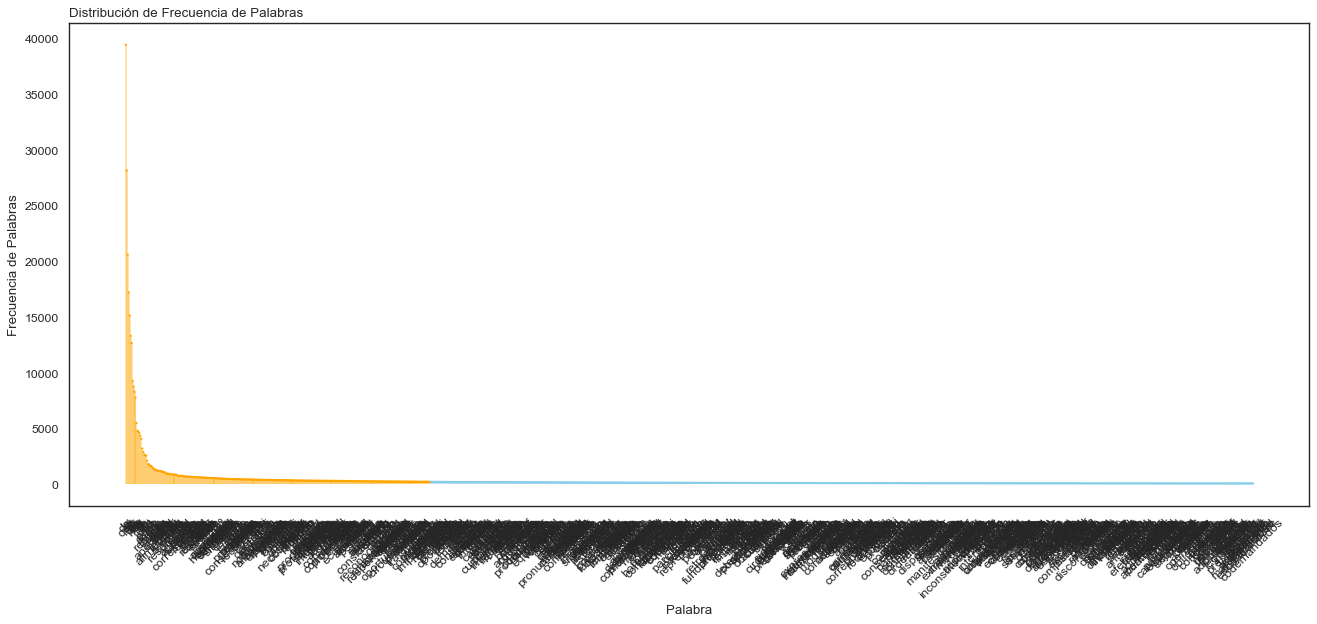

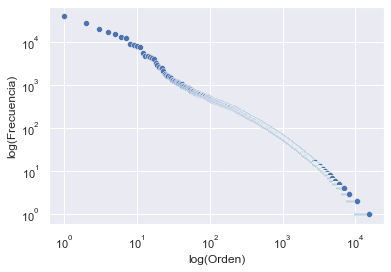

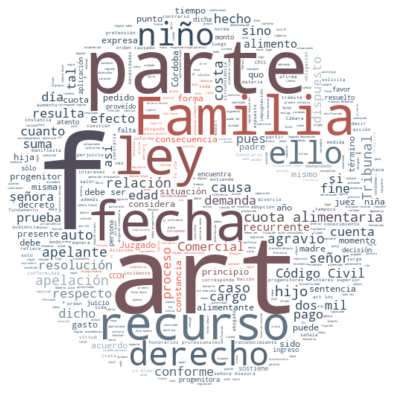

Fuero: LABORAL


Las 50 palabras más frecuentes son:
palabra
de            3704
la            3539
el            2150
que           1834
en            1694
a             1662
por           1309
y             1280
del           1099
los            798
se             635
art            508
las            500
con            410
luis           379
al             366
no             347
vocal          344
lo             338
su             322
ley            318
señor          279
expediente     274
un             255
n              239
doctor         236
dijo           236
nro            235
rubio          228
para           219
tribunal       206
es             202
sala           201
blanc          199
angulo         198
me             191
mercedes       191
sentencia      185
e              178
nº             178
enrique        178
recurso        177
arabel         176
eugenio        172
acuerdo        158
laboral        155
fs             151
fecha          151
voto           149
primera 

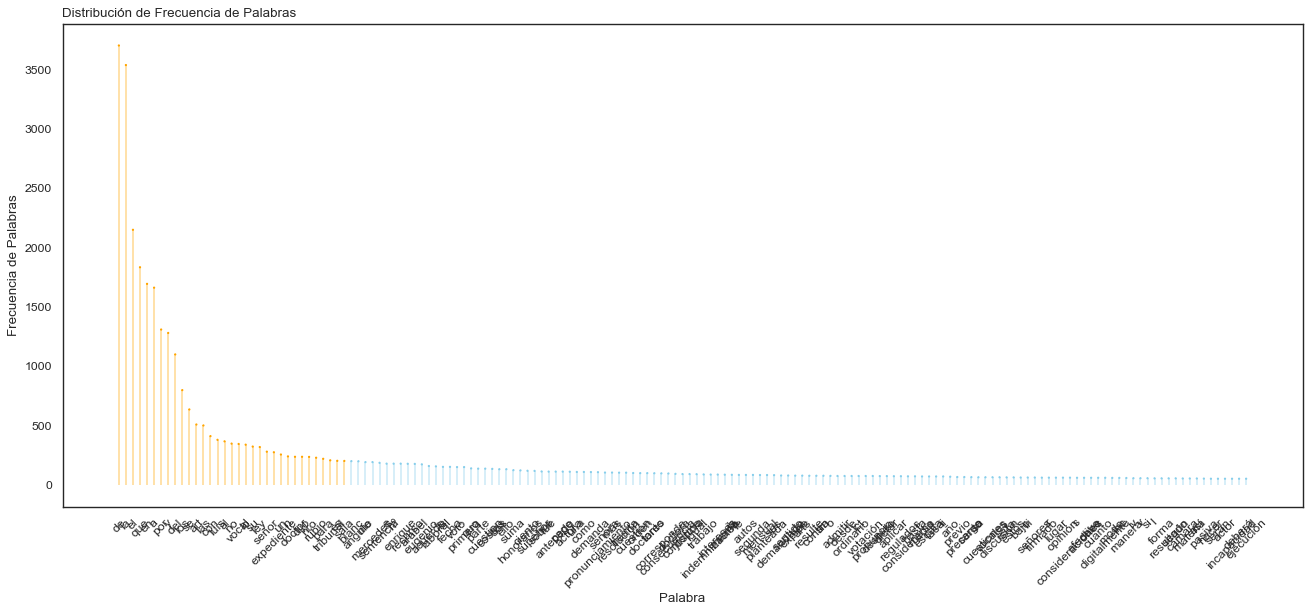

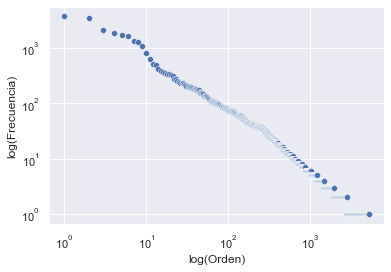

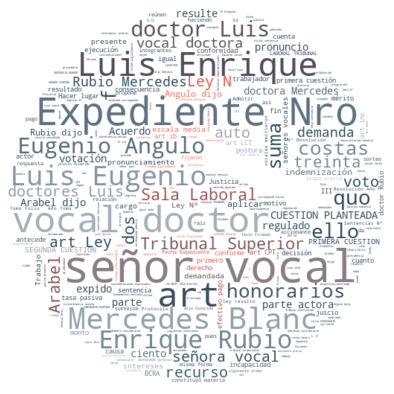

Fuero: MENORES


Las 50 palabras más frecuentes son:
palabra
de            13745
la             9222
que            5411
y              5160
a              4925
en             4743
el             4679
del            3028
los            2470
por            2326
su             2299
se             2188
con            1945
las            1410
al             1330
no             1179
lo             1091
fs             1007
un              976
niño            939
una             904
para            880
es              804
como            790
derechos        631
art             629
familia         592
ley             591
o               585
sus             580
niña            542
medida          421
autos           405
familiar        398
situación       390
derecho         378
ser             373
ha              352
relación        342
dos             340
protección      337
fecha           335
le              331
ello            320
este            311
adopción        294
niñez           290

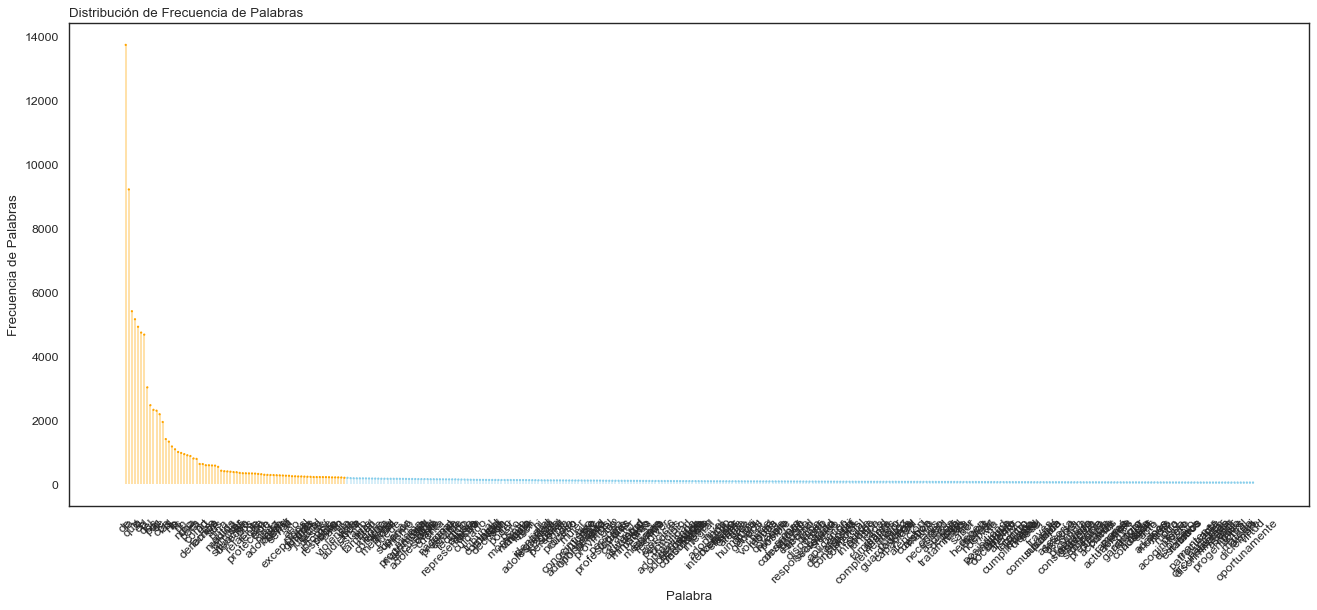

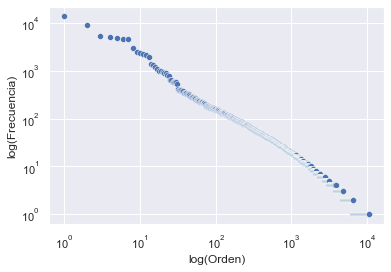

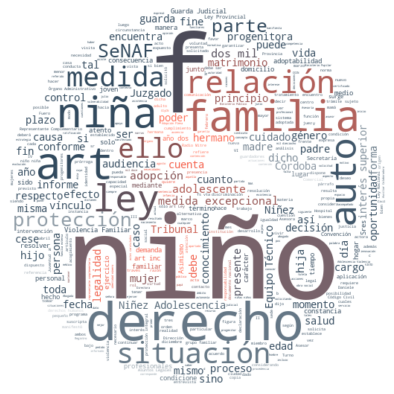

Fuero: PENAL


Las 50 palabras más frecuentes son:
palabra
de            25768
la            17643
que           13921
en            11753
el            11396
y              8222
a              8211
del            6647
por            5588
se             4936
los            4510
las            3506
su             3375
no             3169
con            2983
lo             2625
al             2551
un             2338
una            2200
para           2070
como           1716
es             1628
o              1322
penal          1297
expediente     1289
nro            1243
tribunal       1100
ello           1016
esta            941
art             904
pena            904
vocal           834
ha              827
nº              817
este            796
sala            770
le              752
imputado        745
sus             697
así             662
sentencia       642
entre           637
sin             636
ff              629
sobre           621
si              603
hecho           594
j

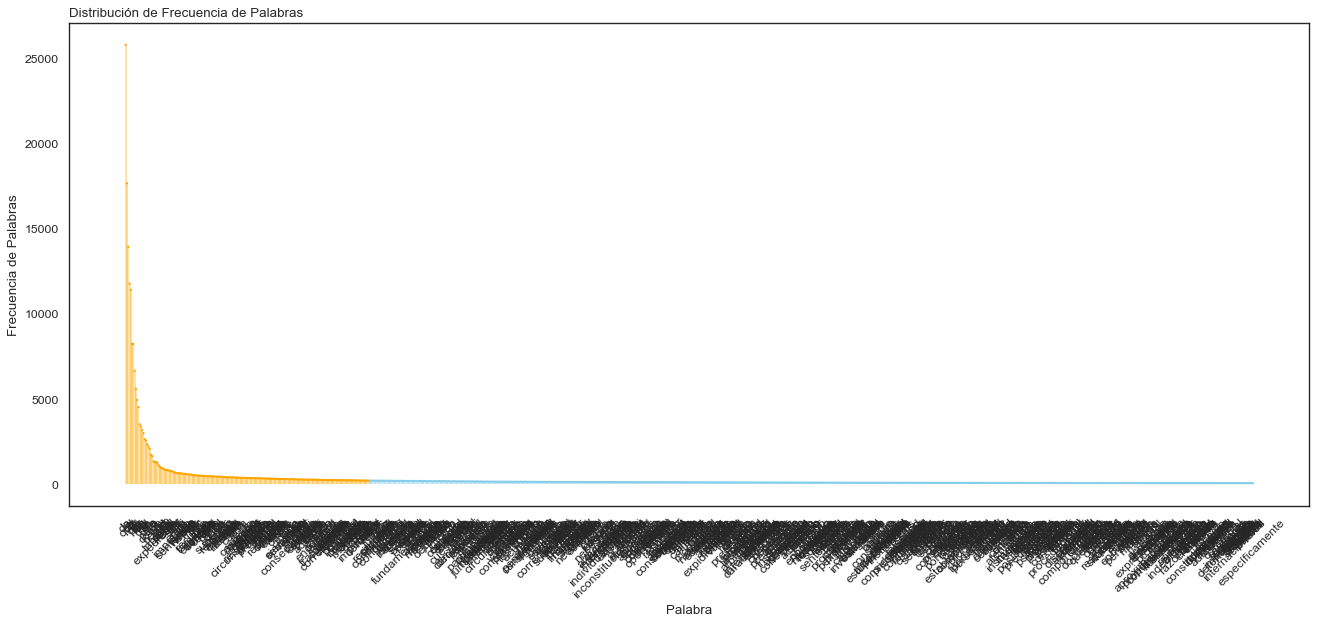

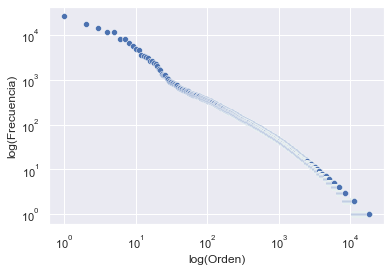

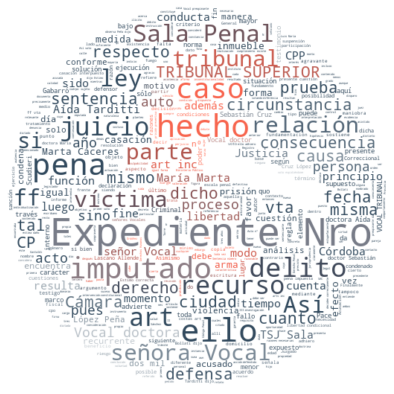


Las palabras que se repiten en todos los fueros son las siguientes: 
{'al', 'que', 'en', 'con', 'a', 'las', 'y', 'su', 'de', 'para', 'se', 'no', 'el', 'un', 'es', 'del', 'los', 'por', 'lo', 'la', 'art'}


In [76]:
# Analizamos por fueros

fueros_lista = []


for fuero in ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']:
    filesDir = f"{CURR_DIR}\\Documentos\\{fuero}"
    palabras_fuero, corpus_dic_fuero = get_palabras(filesDir, fuero_name=fuero, breakpoint=None)

    palabras_df = get_conteo_palabras(palabras_fuero)

    # Convertimos las palabras más frecuentes en un conjunto, a modo de poder utilizar la propiedad intersección (de conjuntos)
    fueros_lista.append(
        set(comparar_frecuencias_palabras(palabras_df, description=f"Fuero: {fuero}\n"))
    )
    
    plot_histogram(
        palabras_df,
        threshold=50,  # Nos quedamos con las palabras con una frecuencia > 50
        y_low=200)
    
    show_zipf(palabras_df)
    
    output_name = f"img/{img_name}_wordcloud_{fuero}.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras_fuero, output_name)
    
# Buscamos la intersección de las palabras comunes de cada fuero
fueros_intersection = fueros_lista[0].intersection(*[x for x in fueros_lista[1:]])

# las palabras frecuentes que se repiten son stopwords
print(f"\nLas palabras que se repiten en todos los fueros son las siguientes: \n{fueros_intersection}")

#### Análisis palabras n-gramas

##### Analizar palabras más frecuentes y menos frecuentes (n-gramas)
Analizar palabras más frecuentes y menos frecuentes.

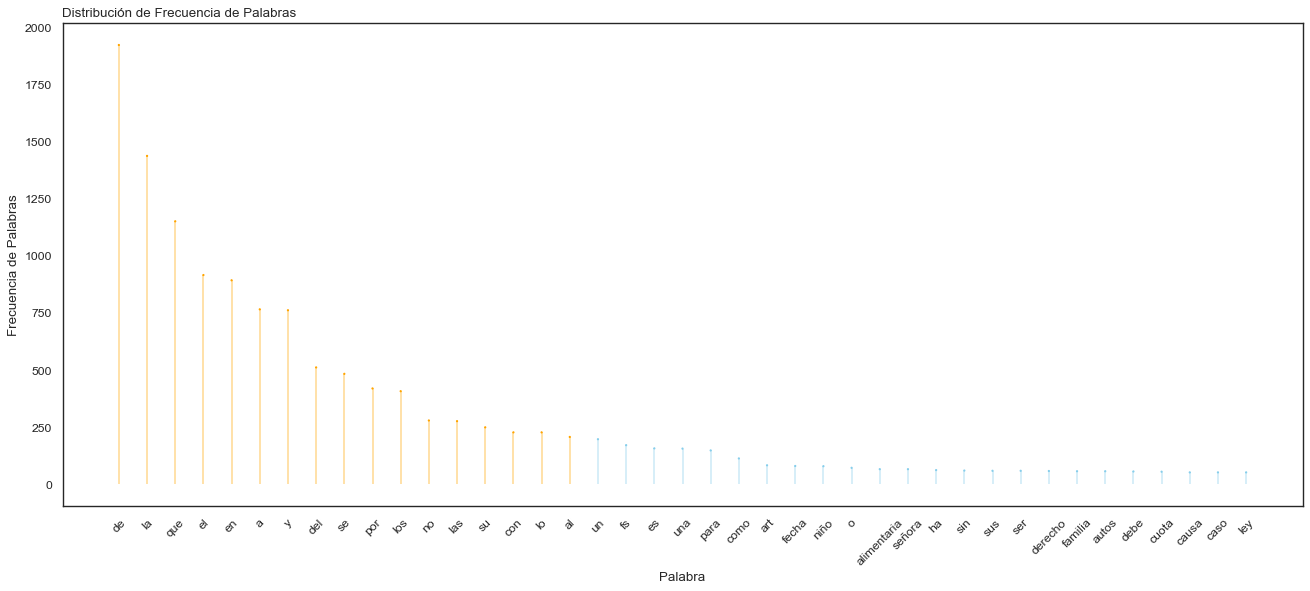

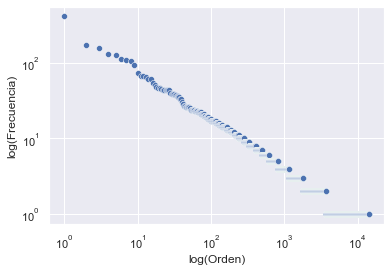

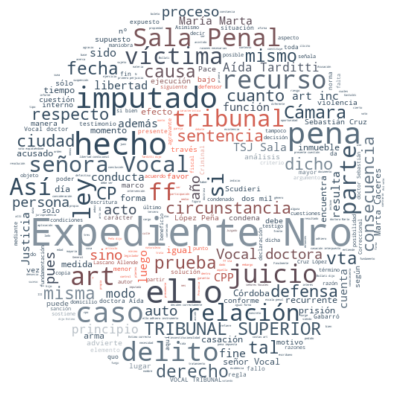

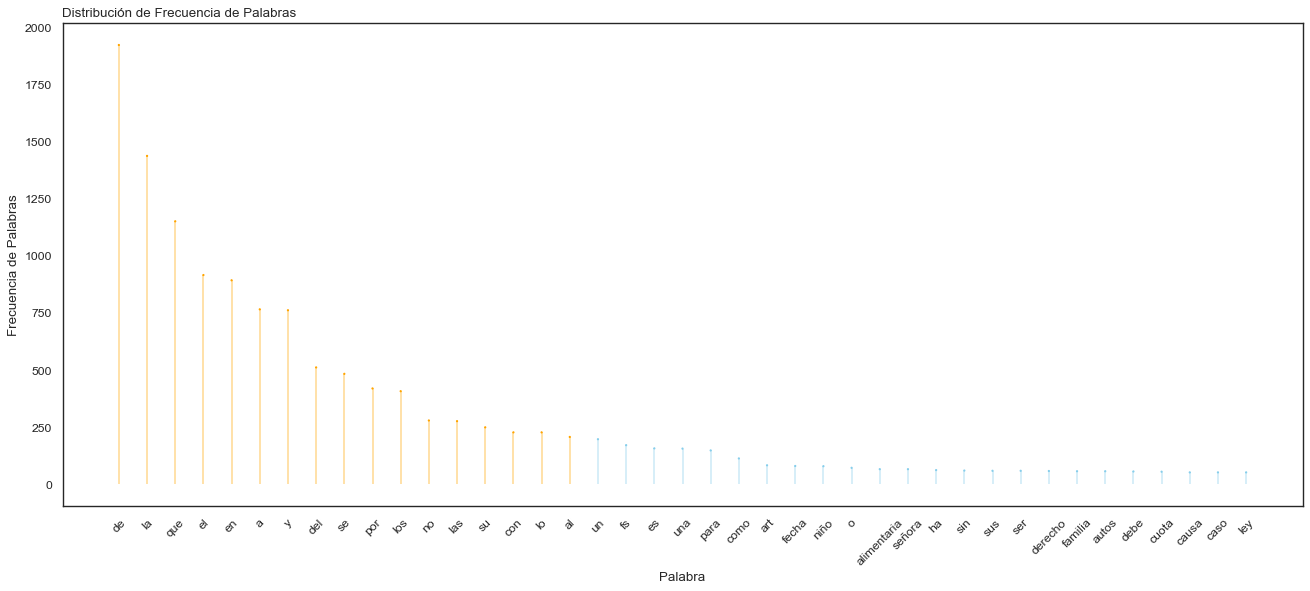

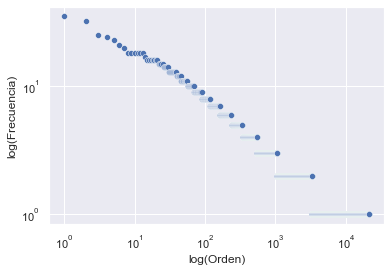

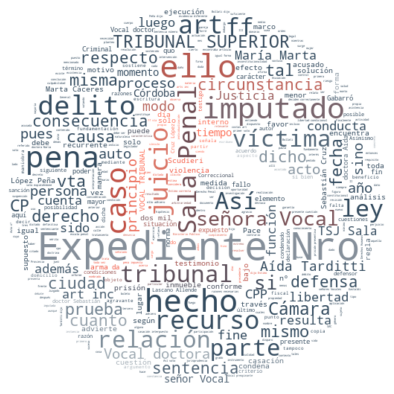

In [77]:
# iteramos por n-gramas de 2 y 3

for n in range(2, 4):
    n_grams = get_n_grams(palabras, n)
    
    ngrams_count = get_conteo_palabras(n_grams)

    plot_histogram(
        frecuencia_palabras_df,
        threshold=50,  # Nos quedamos con las palabras con una frecuencia > 50
        y_low=200)
    
    show_zipf(ngrams_count)
    
    output_name = f"img/{img_name}_wordcloud_{n}-gram.png"

    generar_wordcloud(img_name, STOPWORDS_ES, palabras_fuero, output_name)

##### Elaborar una breve conclusión de lo encontrado

A partir del análisis y las visualizaciones, lo primero que podemos concluir es que es necesario hacer una limpieza de los inputs: remover stopwords, realizar lematización, remover caracteres raros, etc.

Por otro lado, analizando las frecuencias de las palabras pudimos verificar la ley de Zipf, y a la vez notamos que las palabras más frecuentes independientemente del fuero corresponden a las denominadas stopwords. Recién al momento de armar la nube de palabras, pudimos ver con mayor claridad cuáles son las más utilizadas en los documentos, dado que hicimos una limpieza de stopwords.